<a href="https://colab.research.google.com/github/hzhe5009/CS36-Capstone-LSTM/blob/master/GRU_timestep_60(Huixian_Zheng_480070588).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, LeakyReLU,Dropout, GRU, concatenate,Input
from tensorflow.keras import Sequential
from sklearn.model_selection import train_test_split
from matplotlib import pyplot
from datetime import datetime, timedelta, time
%matplotlib inline

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
data_path = '/content/gdrive/My Drive/ctx/combine_data/partzone3month.csv'
new_select_data = pd.read_csv(data_path)

new_select_data['pickup_time_g_index'] = pd.to_datetime(new_select_data['pickup_time_g']) #, format='%Y/%m/%d %I:%M:%S %p', errors='ignore')
new_select_data['pickup_time_g'] = new_select_data['pickup_time_g_index'].copy()
new_select_data.set_index('pickup_time_g_index',inplace=True)
new_select_grouper = new_select_data.groupby('LocationID')
train_data, label_data = [],[]
for each_loc in new_select_grouper:
  location_data = each_loc[1]
  first_time = True
  location_data_sample = location_data.sample(frac=0.001, random_state=2020)
  for index, row in location_data_sample.iterrows():
    this_time = row['pickup_time_g']
    time_window = (location_data['pickup_time_g']>=this_time - timedelta(minutes=60))&(location_data['pickup_time_g']<=this_time - timedelta(minutes=1))
    window_items = location_data[time_window]
    if len(window_items) == 60:
        pu_day_cat = to_categorical(window_items['day'], num_classes=32)
        pu_week_cat = to_categorical(window_items['weekday'], num_classes=7)
        hour_cat = to_categorical(window_items['hour'], num_classes=25)
        minute_cat = to_categorical(window_items['minute'], num_classes=60)
        if first_time:
          first_time = False
          locat_cat = to_categorical(window_items['LocationID'], num_classes=265)
        train_data.append(np.hstack((pu_day_cat,pu_week_cat,hour_cat,minute_cat,locat_cat,
                                    window_items['minute_demand'].values.reshape(-1,1))))
        label_data.append(row['15_demand'])

train_data = np.array(train_data)
label_data = np.array(label_data)
X_tr, X_val, y_tr, y_val = train_test_split(train_data, label_data, test_size=0.1, random_state=2020)

In [0]:
# define model
model = Sequential()
model.add(GRU(512, batch_input_shape=(None, 60, 7+32+25+60+1+265)))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.3))
model.add(Dense(512))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.3))
model.add(Dense(265))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.3))
model.add(Dense(1, activation='relu'))
print(model.summary())

# compile the model
model.compile(loss='mean_squared_error', metrics=['mse', 'mae', 'mape'], optimizer='adam')
history = model.fit(X_tr, y_tr, epochs=6, verbose=2, validation_data=(X_val, y_val))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 512)               1388544   
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               262656    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 265)               1

In [0]:
# evaluate the model
train_metric = model.evaluate(X_tr, y_tr, verbose=2)
test_metric = model.evaluate(X_val, y_val, verbose=2)
print(train_metric)
print(test_metric)

472/472 - 43s - loss: 24.8628 - mse: 24.8826 - mae: 2.4111 - mape: 125326704.0000
53/53 - 5s - loss: 29.6528 - mse: 29.7112 - mae: 2.7508 - mape: 136321296.0000
[24.86281967163086, 24.882587432861328, 2.411133289337158, 125326704.0]
[29.652753829956055, 29.711225509643555, 2.750803232192993, 136321296.0]


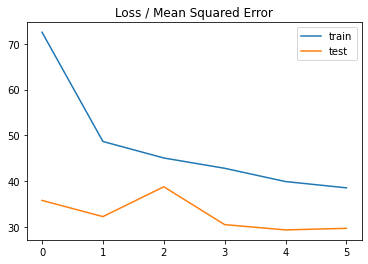

In [0]:
# plot loss during training
pyplot.title('Loss / Mean Squared Error')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [0]:
data_path = '/content/gdrive/My Drive/ctx/combine_data/2019test/All_Demand_2019_3months.csv'
new_select_data = pd.read_csv(data_path)

new_select_data['pickup_time_g_index'] = pd.to_datetime(new_select_data['pickup_time_g']) #, format='%Y/%m/%d %I:%M:%S %p', errors='ignore')
new_select_data['pickup_time_g'] = new_select_data['pickup_time_g_index'].copy()
new_select_data.set_index('pickup_time_g_index',inplace=True)
new_select_grouper = new_select_data.groupby('LocationID')
train_data, label_data = [],[]
for each_loc in new_select_grouper:
  location_data = each_loc[1]
  first_time = True
  location_data_sample = location_data.sample(frac=0.001, random_state=2020)
  for index, row in location_data_sample.iterrows():
    this_time = row['pickup_time_g']
    time_window = (location_data['pickup_time_g']>=this_time - timedelta(minutes=15))&(location_data['pickup_time_g']<=this_time - timedelta(minutes=1))
    window_items = location_data[time_window]
    if len(window_items) == 15:
        pu_day_cat = to_categorical(window_items['day'], num_classes=32)
        pu_week_cat = to_categorical(window_items['weekday'], num_classes=7)
        hour_cat = to_categorical(window_items['hour'], num_classes=25)
        minute_cat = to_categorical(window_items['minute'], num_classes=60)
        if first_time:
          first_time = False
          locat_cat = to_categorical(window_items['LocationID'], num_classes=265)
        train_data.append(np.hstack((pu_day_cat,pu_week_cat,hour_cat,minute_cat,locat_cat,
                                    window_items['minute_demand'].values.reshape(-1,1))))
        label_data.append(row['15_demand'])


train_data = np.array(train_data)
label_data = np.array(label_data)
X_tr, X_val, y_tr, y_val = train_test_split(train_data, label_data, test_size=0.1, random_state=2020)

In [0]:
test_metric = model.evaluate(X_val, y_val, verbose=2)
print(test_metric)

53/53 - 1s - loss: 33.8538 - mse: 34.1694 - mae: 2.9778 - mape: 207857024.0000
[33.85384750366211, 34.169429779052734, 2.9777724742889404, 207857024.0]
